In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

data = np.load("recording.npy")
print(data.shape)

(61000192,)


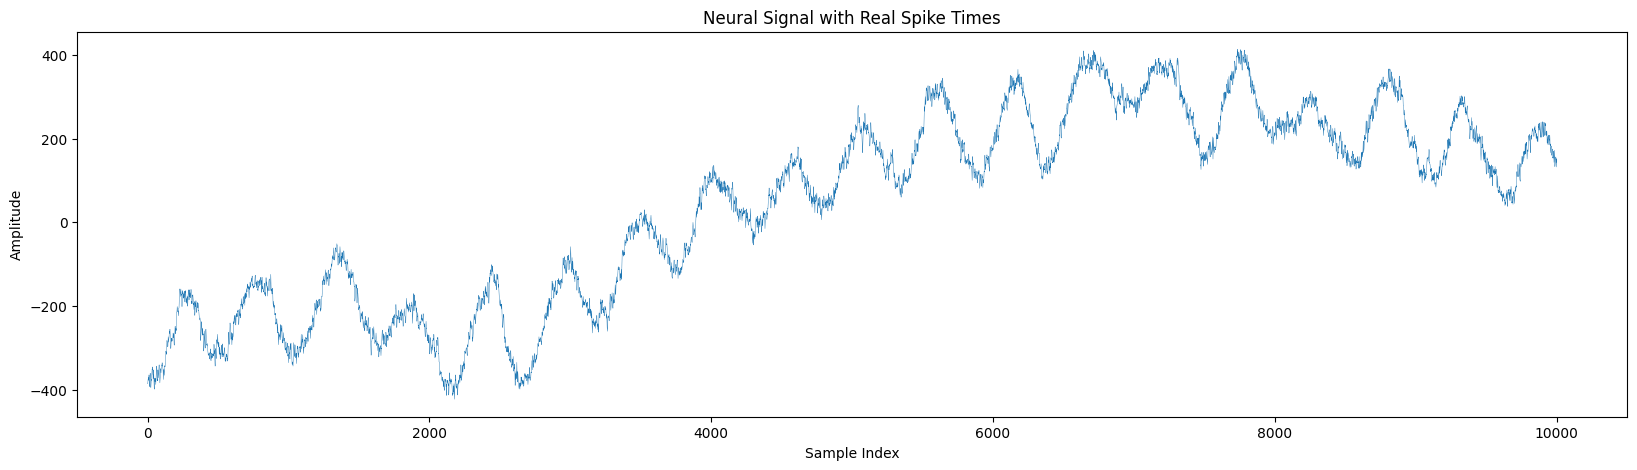

In [3]:
"""
Plot ground-truth spikes
"""
# Number of data points to plot
for a in range(1):
    #plt.ylim(-100,150)
    plt.rcParams['figure.figsize'] = [20, 5]
    
    num_points_min = 10000*a
    num_points_max = 10000*(a+1)#data.shape[0]
    colors = ["red", "black", "lime"]

    # Plot
    plt.plot(np.linspace(start=num_points_min, stop=num_points_max,num=num_points_max-num_points_min), data[num_points_min:num_points_max], label='Neural Signal', zorder=1, linewidth=0.3)
    """filter_condition = (spike_times < num_points_max) & (spike_times > num_points_min)
    zoomed = spike_times[filter_condition]
    #plt.scatter(zoomed, data[zoomed], color=[colors[i] for i in spike_classes[filter_condition]], label='Real Spike Times', zorder=2, s= 5)
    for i in range(zoomed.shape[0]):
        plt.axvline(zoomed[i], color=[colors[i] for i in spike_classes[filter_condition]][i], label='Real Spike Times', zorder=2, linewidth=.5)"""

    plt.title('Neural Signal with Real Spike Times')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    #plt.legend()

    plt.show()


In [4]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    if not(0<low and 0<high and high<1):
        raise RuntimeError(f"bandpass_filter 0<{low} and 0<{high}<1")
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

#data_filtered = bandpass_filter(data_normalized, 300, 3000, 24000)

In [5]:
def getSpiketimes(data, threshold, overlap_range):
    # if data is normalized, no need to adjust for variance. can just check threshold
    possible_spikes = np.array([i for i in range(data.shape[0]) if data[i]>=threshold])
    
    current = 0
    overlap_filtered = [possible_spikes[current]]
    for i in range(1, possible_spikes.shape[0]):
        if np.abs(possible_spikes[current] - possible_spikes[i]) <= overlap_range:
            continue
        current = i
        overlap_filtered.append(possible_spikes[i])
    return np.array(overlap_filtered)
#possible_spikes = getSpiketimes(data_filtered, 0.2)

In [7]:
def getSpikeRanges(data, possible_spikes, spike_before, spike_after):
    """extracts possible spiketimes from data
    1. filter for only points >= threshold
    2. filter out points, which are too close too another, because they are probably from the same spike
    3. extract the window around the spiketimes, i.e. [i-spike_before, i+spike_after] 

    may return inhomogenous arrays
    """
    
    spike_ranges = []
    for i in possible_spikes:
        before = i-spike_before 
        after = i+spike_after
        if i-spike_before < 0:
            before = 0
            spike_range = data[int(before):int(after)]
            # ensure all ranges are same length
            spike_range = np.pad(spike_range, (spike_before+spike_after-len(spike_range), 0), mode="constant", constant_values=0)
            spike_ranges.append(spike_range)
            continue
        elif i+spike_after >= data.shape[0]:
            after = i
            spike_range = data[int(before):int(after)]
            spike_range = np.pad(spike_range, (0, spike_before+spike_after-len(spike_range)), mode="constant", constant_values=0)
            spike_ranges.append(spike_range)
            continue
        spike_range = data[int(before):int(after)]
        spike_ranges.append(spike_range)
    return np.array(spike_ranges)

In [8]:
from scipy.signal import welch
from scipy.stats import kurtosis, skew, entropy

def getFeatures(spike_ranges):
    all_features = []

    for range in spike_ranges:
        range_features = []

        # data itself
        range_features = np.append(range_features, range)
        # highest amplitude
        #range_features = np.append(range_features, np.max(range))
        # lowest amplitude
        range_features = np.append(range_features, np.min(range))
        # highest absolute amplitude
        range_features = np.append(range_features, np.max(np.abs(range)))
        # peak to peak amplitude
        range_features = np.append(range_features, np.ptp(range))
        # dominant frequency
        #range_features = np.append(range_features, np.argmax(np.abs(np.fft.fft(range))))
        # Power Spectral Density (PSD)
        #range_features = np.append(range_features, welch(range,fs=24000, nperseg=10)[1])
        # Kurtosis
        #range_features = np.append(range_features, kurtosis(range))
        # Entropy
        #range_features = np.append(range_features, entropy(range))
        # Skewness
        #range_features = np.append(range_features, skew(range))
        # Slope
        #range_features = np.append(range_features, np.gradient(range))
        # Autokorrelation
        #range_features = np.append(range_features, np.correlate(range, range, mode='full')[-1])
        # signal energy
        #range_features = np.append(range_features, np.sum(range ** 2))
        # Root Mean Square
        #ange_features = np.append(range_features, np.sqrt(np.mean(range ** 2)))
        # Area under graph
        range_features = np.append(range_features, np.trapezoid(np.abs(range)))


        #range_features = np.array(range_features).reshape(1, -1).flatten()
        all_features.append(range_features)
    
    return np.array(all_features)

preprocessing


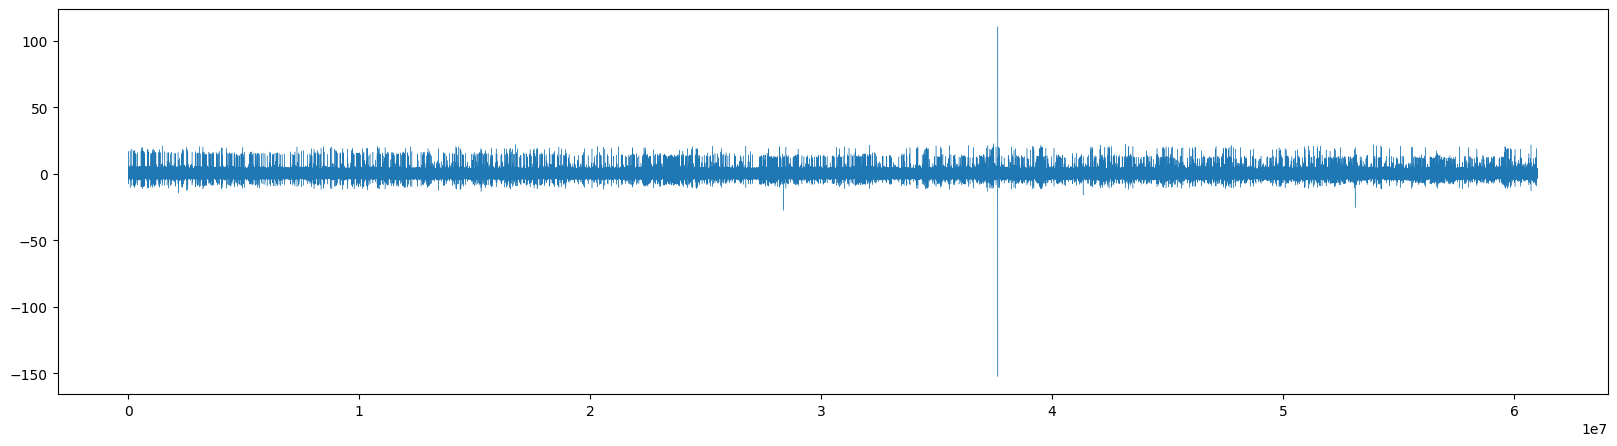

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

samplingRate = 32051
print("preprocessing")
data_processed = data
data_band = bandpass_filter(data_processed, lowcut=500, highcut=3000, fs=samplingRate)

data_processed = StandardScaler().fit_transform(data_band.reshape(-1, 1)).flatten()

# Number of data points to plot
for a in range(1):
    plt.rcParams['figure.figsize'] = [20, 5]
    
    num_points_min = 0
    num_points_max = data.shape[0]
    colors = ["red", "black", "lime"]

    # Plot
    plt.plot(np.linspace(start=num_points_min, stop=num_points_max,num=num_points_max-num_points_min), data_processed[num_points_min:num_points_max], label='Neural Signal', zorder=1, linewidth=0.3)
    #plt.legend()

    plt.show()



In [184]:
print("extract spike ranges")
possible_spikes = getSpiketimes(data_processed, threshold=3.434633422988655, overlap_range=75)
spike_ranges = getSpikeRanges(data_processed, possible_spikes, spike_before=50, spike_after=50)
print(possible_spikes)
print(np.shape(spike_ranges))

extract spike ranges
[    4150     5039     7308 ... 60987209 60987960 60990272]
(18365, 100)


In [185]:
def predictSpiketimes(data, threshold, overlap_range):
    data_processed = StandardScaler().fit_transform(data.reshape(-1, 1)).flatten()
    # threshold=3.434633422988655, overlap_range=75 work great
    possible_spikes = getSpiketimes(data_processed, threshold=threshold, overlap_range=overlap_range)
    return possible_spikes

In [186]:
print("extract features")
features = getFeatures(spike_ranges)
features = StandardScaler().fit_transform(features)
print(np.shape(features))

extract features
(18365, 104)


In [189]:
print("apply pca on features")
pca = PCA(n_components=2).fit(features)
pca_out = pca.transform(features)
print(pca_out.shape)
print(pca.explained_variance_ratio_)

apply pca on features
(18365, 2)
[0.32408117 0.10544093]


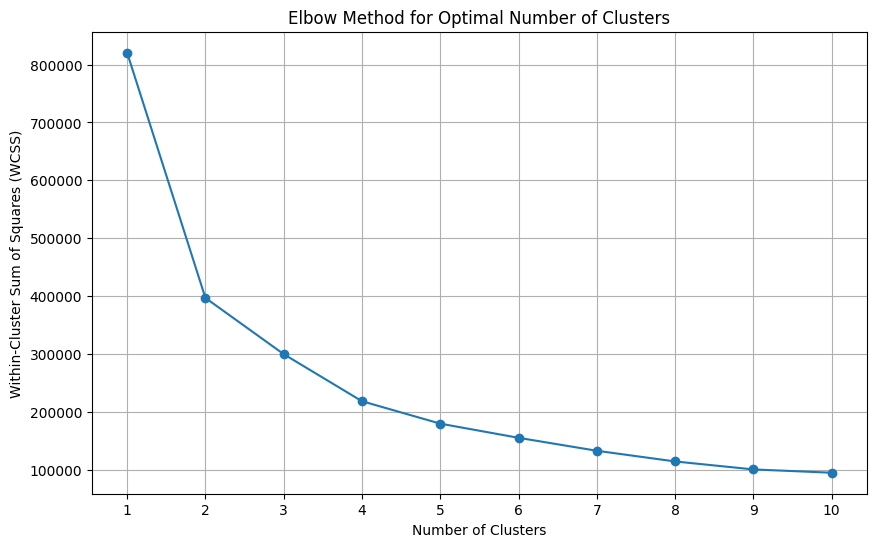

In [190]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Compute KMeans clustering for a range of cluster numbers
wcss = []
cluster_range = range(1, 11)
for n_clusters in cluster_range:
    k = KMeans(n_clusters=n_clusters, random_state=42)
    k.fit(pca_out)

    centroids = k.cluster_centers_
    labels = k.labels_
    # Varianz für jeden Cluster berechnen
    """BaseExceptionGroupvariances = []
    for i in range(k.n_clusters):
        # Wähle alle Punkte im Cluster i aus
        cluster_points = pca_out[labels == i]
        # Berechne die Varianz für diesen Cluster
        variance = np.mean(np.sum((cluster_points - centroids[i]) ** 2, axis=1))
        variances.append(variance)
        wcss.append(np.sum(variances))"""
    wcss.append(k.inertia_)

# Step 2: Plot the WCSS values against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [179]:
print("clustering")
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters).fit(pca_out)

cluster_labels = kmeans.labels_

clustering


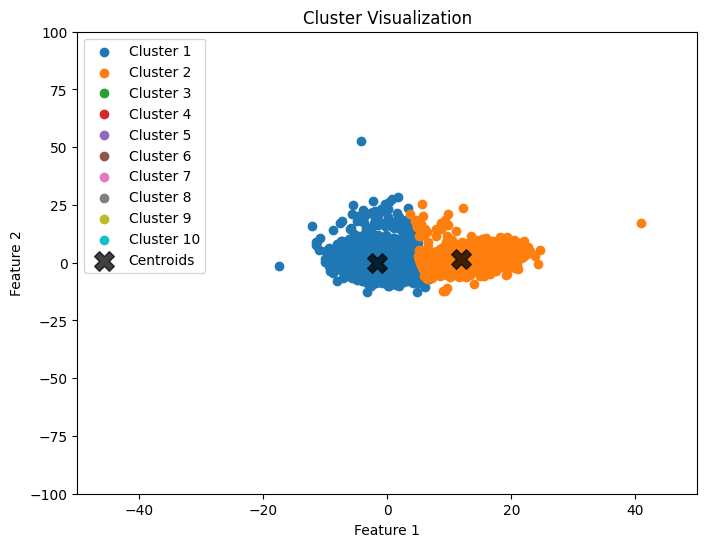

In [191]:
# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.ylim(-100,100)
plt.xlim(-50,50)
for i in range(n_clusters):
    cluster_points = pca_out[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75, marker='X', label='Centroids')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

In [ ]:
def plot_clusters_3d(reduced_features, labels, big_clusters):
    fig = plt.figure(figsize=(10, 6))
    plt.ylim(-100,50)
    plt.xlim(-50,50)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each cluster with a different color
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = reduced_features[labels == label]
        if label in big_clusters:
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {label}', alpha=0.6)
        else:
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], color='red', label='Outliers', edgecolor='k', s=100)
    
    ax.set_title('KMeans Clusters')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.show()
plot_clusters_3d(pca_out, kmeans.labels_, np.unique(kmeans.labels_))

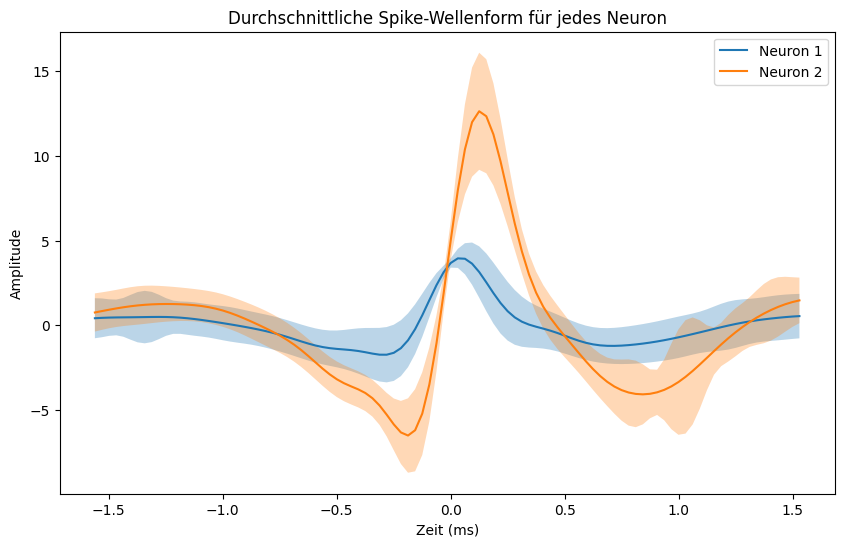

In [194]:
# Initialisierung für Durchschnitts- und Standardabweichungsberechnungen
num_clusters = len(np.unique(cluster_labels))
average_waveforms = []
std_waveforms = []
time_axis = np.arange(-50, 50) / samplingRate * 1000  # in ms, falls spike_before und spike_after = 50

# Berechne Durchschnitt und Standardabweichung für jeden Cluster
for cluster_id in range(num_clusters):
    cluster_spikes = spike_ranges[cluster_labels == cluster_id]
    avg_waveform = cluster_spikes.mean(axis=0)
    std_waveform = cluster_spikes.std(axis=0)
    
    average_waveforms.append(avg_waveform)
    std_waveforms.append(std_waveform)

# Visualisiere die Durchschnittswellenformen mit Standardabweichung
plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    plt.plot(time_axis, average_waveforms[cluster_id], label=f'Neuron {cluster_id+1}')
    plt.fill_between(
        time_axis,
        average_waveforms[cluster_id] - std_waveforms[cluster_id],
        average_waveforms[cluster_id] + std_waveforms[cluster_id],
        alpha=0.3
    )

plt.title("Durchschnittliche Spike-Wellenform für jedes Neuron")
plt.xlabel("Zeit (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

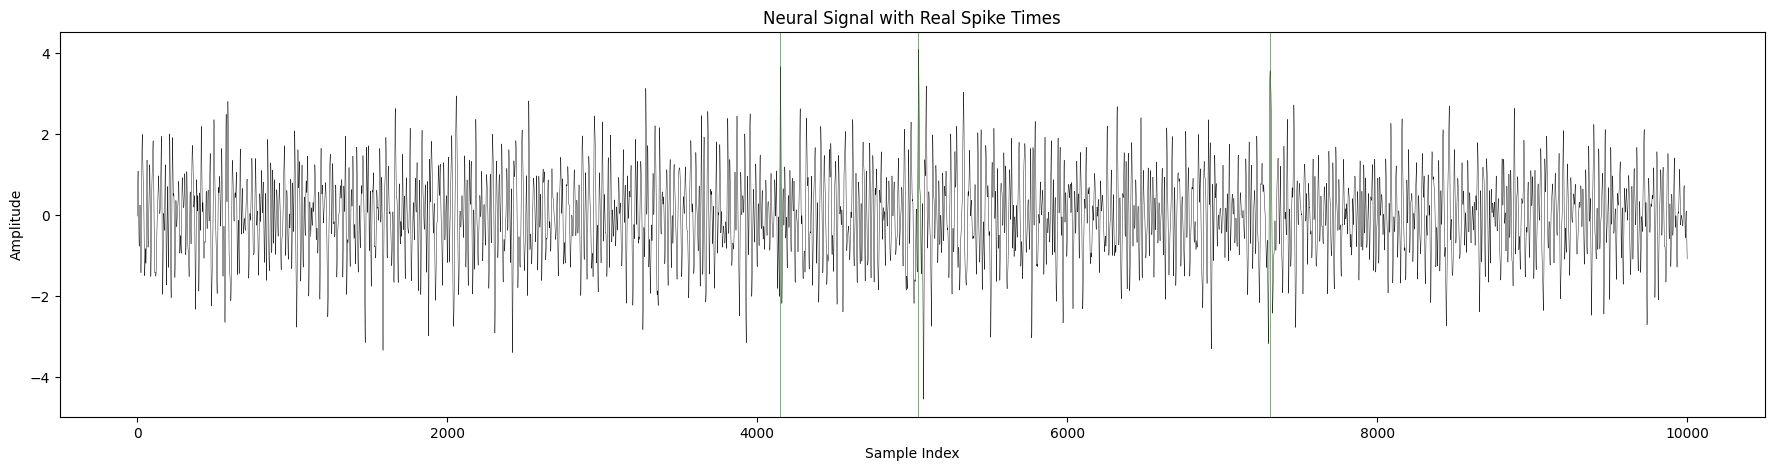

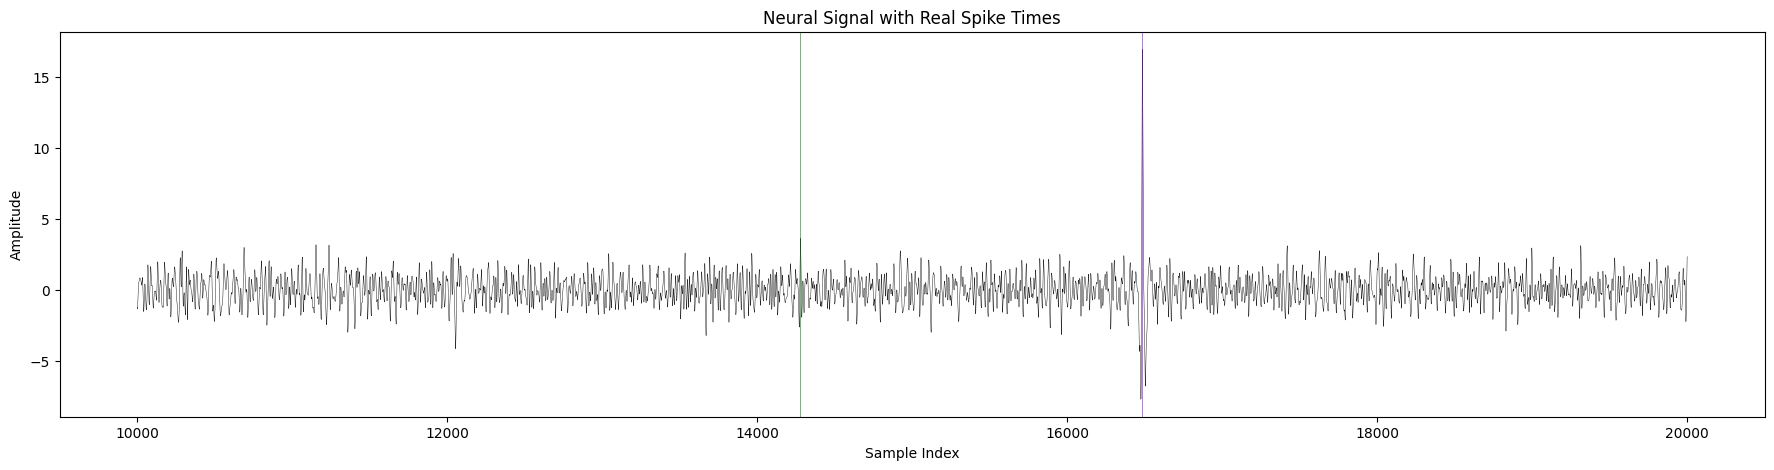

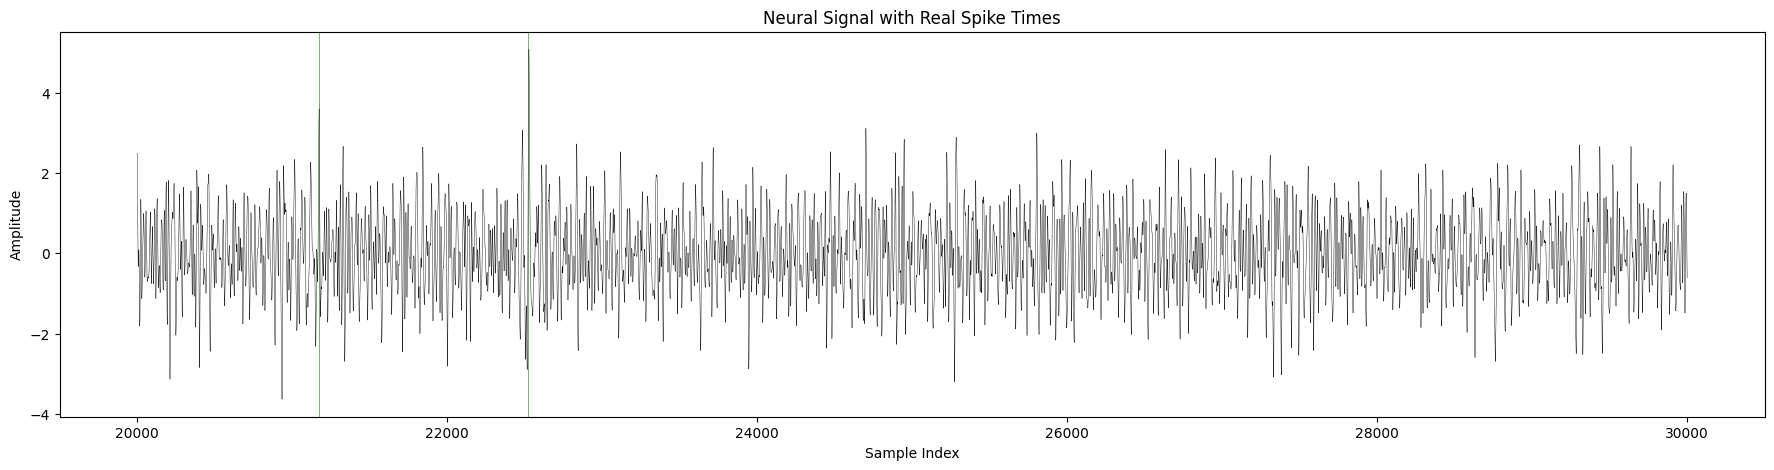

In [193]:
"""
Plot detected spikes
"""
# Number of data points to plot
for a in range(3):
    plt.rcParams['figure.figsize'] = [22, 5]
    
    num_points_min = 10000*a
    num_points_max = 10000*(a+1)#data.shape[0]
    cluster_colors = ["green", "#8f00ff", "blue", "black"] # 8f00ff=lila
    colors = ["magenta", "red", "orange", "gold"]

    # Plot
    plt.plot(np.linspace(start=num_points_min, stop=num_points_max,num=num_points_max-num_points_min), data_processed[num_points_min:num_points_max], label='Neural Signal', 
             zorder=1, linewidth=0.3, color="black")
    #detected
    filter_condition = (possible_spikes < num_points_max) & (possible_spikes > num_points_min)
    zoomed = possible_spikes[filter_condition]
    #plt.scatter(zoomed, data[zoomed], color=[colors[i] for i in spike_classes[filter_condition]], label='Real Spike Times', zorder=2, s= 5)
    for i in range(zoomed.shape[0]):
        plt.axvline(zoomed[i], color=[cluster_colors[i] for i in cluster_labels[filter_condition]][i], label='Predicted Spike Times', zorder=2, linewidth=.4)

    plt.title('Neural Signal with Real Spike Times')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    #plt.legend()

    plt.show()